<a href="https://colab.research.google.com/github/stuthiudupa/IEEE-OSPI-YOLOv5/blob/main/Roboflow_Train_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.70 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (11034/11034), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Download Custom Dataset

---



We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format.The Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.



In [ ]:
#follow the link below to get your download code from from Roboflow



In [ ]:
%cd /content/yolov5
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="eGE6sv2Kt4h7QqYJSjKK")
project = rf.workspace("stuthi-udupas-workspace").project("ieee-ospi-empty-seat-detection-zk7lg")
dataset = project.version(1).download("yolov5")

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 941.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to IEEE-OSPI-Empty-Seat-Detection-1 in yolov5pytorch:: 100%|██████████| 492/492 [00:00<00:00, 7449.00it/s]


In [ ]:
#YAML file Roboflow wrote that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- empty
- occupied
nc: 2
roboflow:
  license: CC BY 4.0
  project: ieee-ospi-empty-seat-detection
  url: https://universe.roboflow.com/stuthi-udupas-workspace/ieee-ospi-empty-seat-detection/dataset/1
  version: 1
  workspace: stuthi-udupas-workspace
test: ../test/images
train: IEEE-OSPI-Empty-Seat-Detection-1/train/images
val: IEEE-OSPI-Empty-Seat-Detection-1/valid/images


# Define Model Configuration and Architecture

A yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#model configuration
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector


Arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-11-26 12:30:31.097097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 12:30:31.097167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 12:30:31.097210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 12:30:32.455271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/IEEE-OSPI-Empty-Seat-Detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

In [ ]:
# we can also output some older school graphs if the tensor board isn't working
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Visualize Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
# ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

In [ ]:
%ls runs/train/yolov5s_results/weights

In [ ]:
import os

# Get the directory where the .txt file is saved
result_directory = "/content/yolov5/IEEE-OSPI-Empty-Seat-Detection-1/test/images"

# List the contents of the directory
files = os.listdir(result_directory)

print(files)


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/IEEE-OSPI-Empty-Seat-Detection-1/test/images

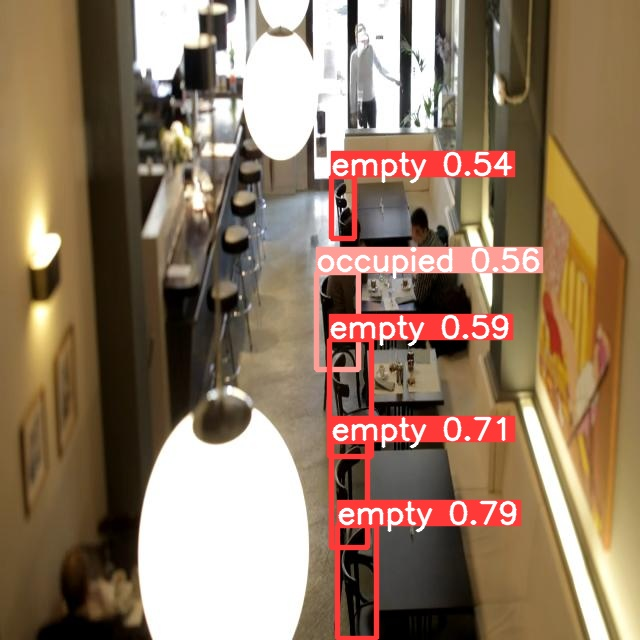

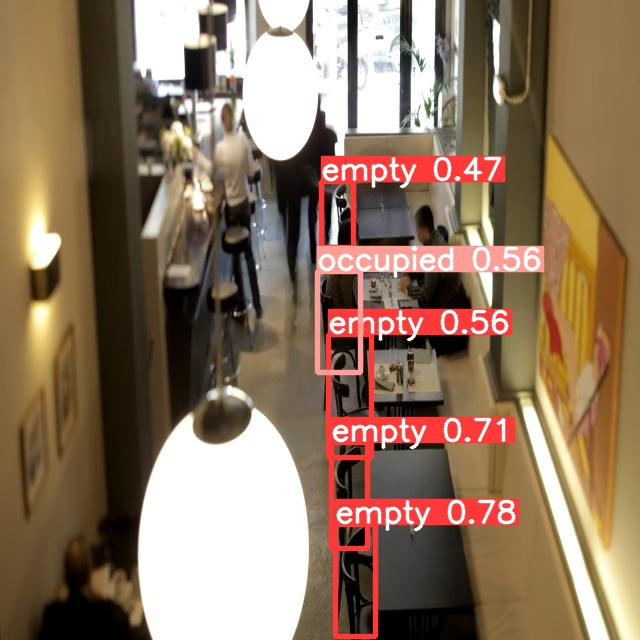

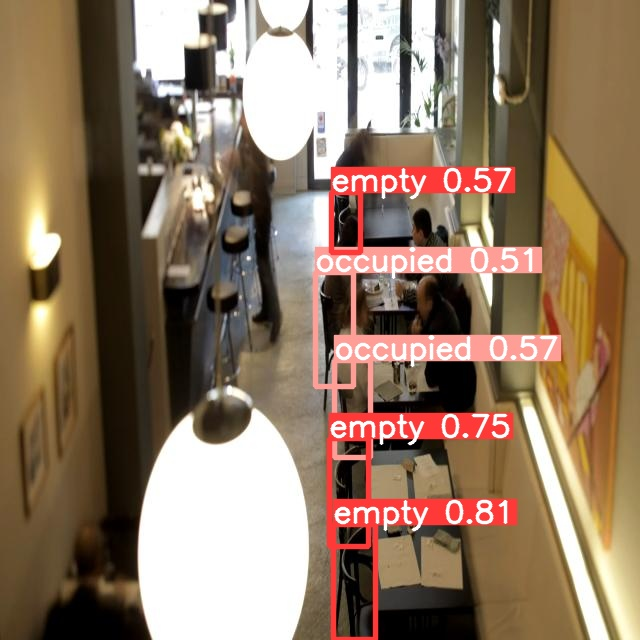

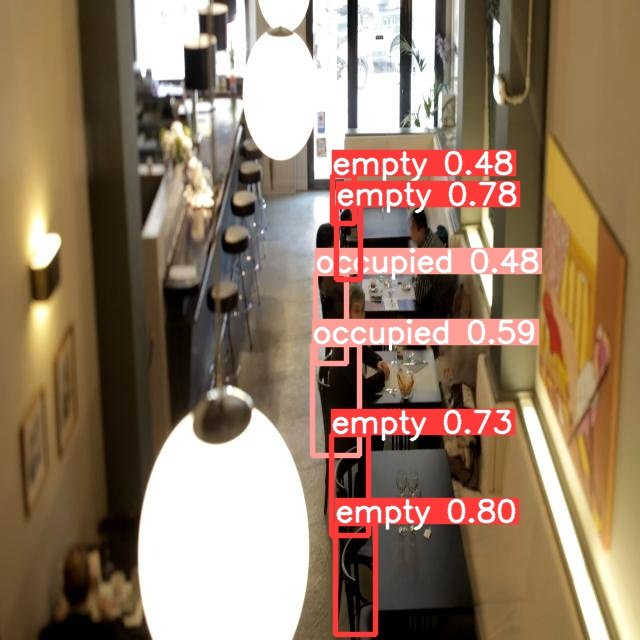

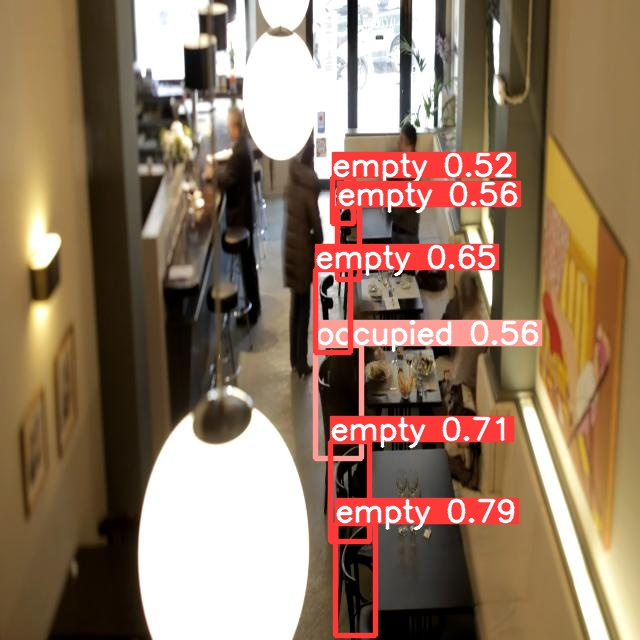

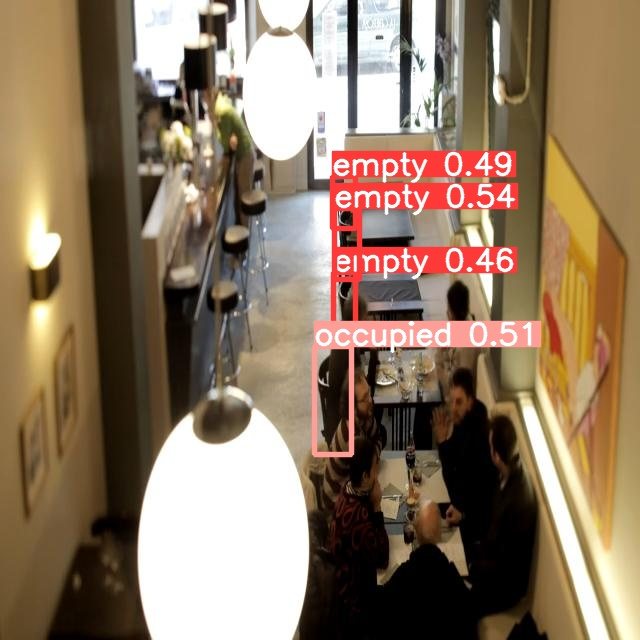

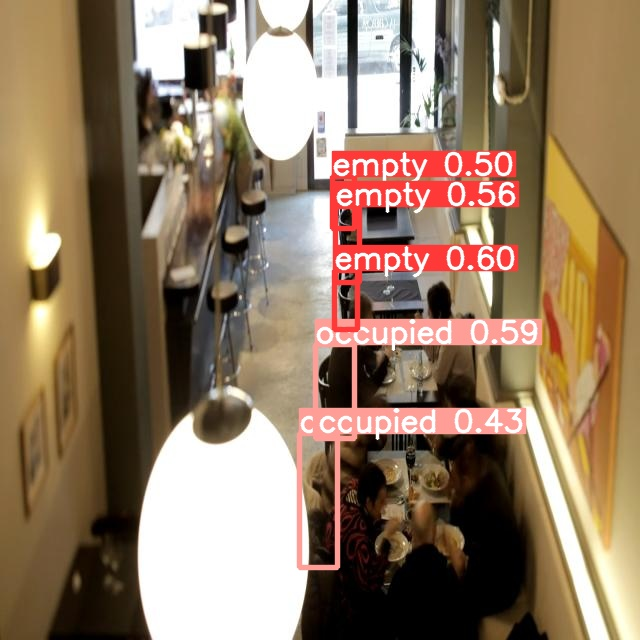

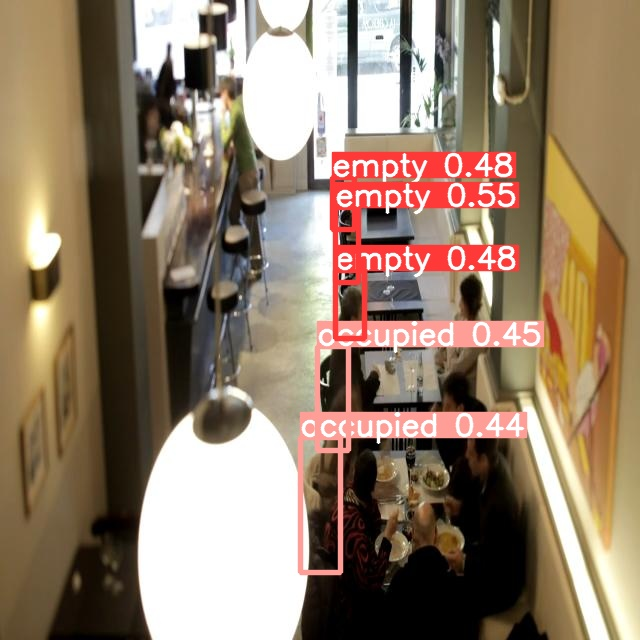

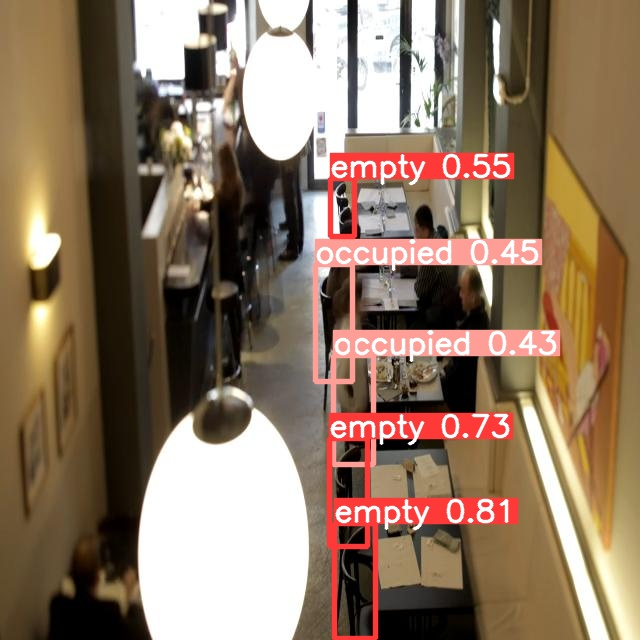

In [ ]:
#display inference on ALL test images


import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img-size 416 --source https://imgur.com/rJVPfrI.mp4 --save-txt --save-conf

In [ ]:
# Get the directory where the .txt file is saved
result_directory = "runs/detect/exp2/labels"

# List the contents of the directory
files = os.listdir(result_directory)

print(files)

In [ ]:
import cv2
import os

#Directory where the annotated frames are saved
result_directory = "runs/detect/exp2/labels"

# List all the annotation text files in the directory
annotation_files = [file for file in os.listdir(result_directory) if file.endswith(".txt")]

# Load the video
video_path = "/content/yolov5/rJVPfrI.mp4"
cap = cv2.VideoCapture(video_path)

# Define the codec and create a VideoWriter object to save the annotated video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_path = "annotated_video.avi"
out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))) if cap.isOpened() else (1920, 1080))

# Sort the annotation files based on their frame numbers
annotation_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

for annotation_file in annotation_files:
    frame_number = int(annotation_file.split('_')[1].split('.')[0])

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame_number_video = int(cap.get(1))

        if frame_number == frame_number_video:
            # Load the predicted bounding boxes for this frame
            txt_file_path = os.path.join(result_directory, annotation_file)

            with open(txt_file_path, "r") as file:
                lines = file.read().strip().split("\n")
                boxes = [list(map(float, line.split())) for line in lines]

            # Annotate the frame with bounding boxes
            for box in boxes:
              x, y, w, h, conf, cls = box
              x1, y1, x2, y2 = int((x - w / 2) * frame.shape[1]), int((y - h / 2) * frame.shape[0]), int((x + w / 2) * frame.shape[1]), int((y + h / 2) * frame.shape[0])
              color = (0, 0, 255)  # Red color for the bounding box
              thickness = 2
              frame = cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
              label = f"Class {int(cls)}: {conf:.2f}"
              frame = cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

            # Write the frame with annotations to the output video
            out.write(frame)

            break

# Release the video objects
cap.release()
out.release()


In [ ]:
# Get the directory where the .txt file is saved
result_directory = "/content/yolov5/"

# List the contents of the directory
files = os.listdir(result_directory)

print(files)


# Export Trained Weights for Future Inference

export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive